### Load and prepare the data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import gresearch_crypto
import gc

from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)

DEBUG = False

In [2]:
train = pd.read_csv('../input/g-research-crypto-forecasting/train.csv').set_index("timestamp")
assets = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
#for assets sorting 
assets_order = pd.read_csv('../input/g-research-crypto-forecasting/supplemental_train.csv').Asset_ID[:14]
assets_order = dict((t,i) for i,t in enumerate(assets_order))

if DEBUG:
    #train = train[1000000:12000000]
    train = train[10000000:]

train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP','Target']] = \
train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP','Target']].astype(np.float32)

train['Target'] = train['Target'].fillna(0)

In [12]:
def preprocess(train, assets, assets_order):
    # VWAP column has -inf and inf values. VWAP_max and VWAP_min will be used for replacement

    VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
    VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
    print(VWAP_max, "\n", VWAP_min)

    train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)
    
    # Get the series of the 'real' record ids for futher matching

    df = train[['Asset_ID', 'Target']].copy()

    times = dict((t,i) for i,t in enumerate(df.index.unique()))
    df['id'] = df.index.map(times)
    df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
    ids = df.id.copy()

    del df    
    
    def add_features(df):
        df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
        df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']

        df['spread'] = df['High'] - df['Low']
        df['mean_trade'] = df['Volume']/df['Count']
        df['log_price_change'] = np.log(df['Close']/df['Open'])
        return df

    train=add_features(train)
    train.shape
    
    scale_features = train.columns.drop(['Asset_ID','Target'])
    RS = RobustScaler()
    train[scale_features] = RS.fit_transform(train[scale_features])
    
    # Filling gaps
    ind = train.index.unique()

    def reindex(df):
        df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
        df = df.fillna(method="ffill").fillna(method="bfill")
        return df

    train=train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
    train.shape
    
    # Matching records and marking generated rows as 'non-real'
    train['group_num'] = train.index.map(times)
    train = train.dropna(subset=['group_num'])
    train['group_num'] = train['group_num'].astype('int')

    train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)

    train['is_real'] = train.id.isin(ids)*1
    train = train.drop('id', axis=1)

    # Features values for 'non-real' rows are set to zeros
    features = train.columns.drop(['Asset_ID','group_num','is_real'])
    train.loc[train.is_real==0, features]=0.
    
    # Sorting assets according to their order in the 'supplemental_train.csv'
    train['asset_order'] = train.Asset_ID.map(assets_order) 
    train=train.sort_values(by=['group_num', 'asset_order'])
    
    targets = train['Target'].to_numpy().reshape(-1, 14)
    #targets = np.expand_dims(targets, axis=1)

    features = train.columns.drop(['Asset_ID', 'Target', 'group_num','is_real'])
    train = train[features]

    train=np.array(train)
    train = train.reshape(-1,14,train.shape[-1])
    #train = np.expand_dims(train, axis=1)
    train.shape
    return train, targets

In [13]:
train, targets = preprocess(train, assets, assets_order)
gc.collect()

### Dataset creation

Samples with a duration of 15 records (minutes) will be formed from the `train` array. Each sample has a target vector corresponding to the 15th record. 

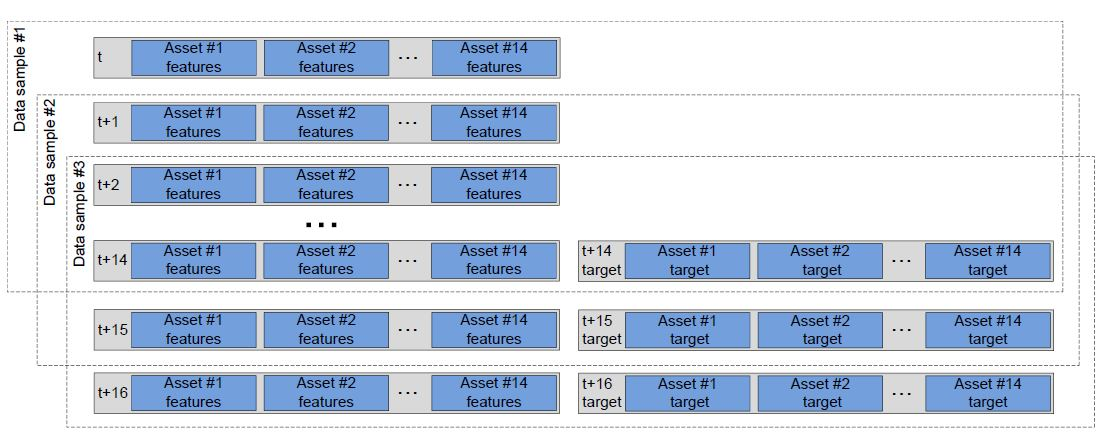

In [14]:
# timeseriesgenerator-like class, except it using target from the last timestep insteed of last+1
class sample_generator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, length):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.length = length
        self.size = len(x_set)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x=[]
        batch_y=[]
        for i in range(self.batch_size):
            start_ind = self.batch_size*idx + i
            end_ind = start_ind + self.length 
            if end_ind <= self.size:
                batch_x.append(self.x[start_ind : end_ind])
                batch_y.append(self.y[end_ind -1])

        return np.array(batch_x), np.array(batch_y)

In [16]:
X_train, X_test = train[:-len(train)//10], train[-len(train)//10:]
y_train, y_test = targets[:-len(train)//10], targets[-len(train)//10:]

BATCH_SIZE=2**10

train_generator = sample_generator(X_train, y_train, length=15, batch_size=BATCH_SIZE)
val_generator = sample_generator(X_test, y_test, length=15, batch_size=BATCH_SIZE)

print(f'Sample shape: {train_generator[0][0].shape}')
print(f'Target shape: {train_generator[0][1].shape}')
gc.collect()

### Training

In [17]:
#https://github.com/tensorflow/tensorflow/issues/37495
def MaxCorrelation(y_true,y_pred):
    """Goal is to maximize correlation between y_pred, y_true. Same as minimizing the negative."""
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return -tf.math.abs(tfp.stats.correlation(y_true_masked,y_pred_masked, sample_axis=None, event_axis=None))

def Correlation(y_true,y_pred):
    return tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))

def masked_mse(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_squared_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_mae(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_absolute_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_cosine(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.cosine_similarity(y_true_masked, y_pred_masked)

def get_model(n_assets=14):  
    x_input = keras.Input(shape=(train_generator[0][0].shape[1], n_assets, train_generator[0][0].shape[-1]))

    branch_outputs = []
        
    for i in range(n_assets):
            # Slicing the ith asset:
        a = layers.Lambda(lambda x: x[:,:, i])(x_input)
        a = layers.Masking(mask_value=0.,)(a)
        #a = layers.BatchNormalization()(a)
        a = layers.LSTM(units=32, return_sequences=True)(a)
        a = layers.LSTM(units=16)(a)
        branch_outputs.append(a)
    
    x = layers.Concatenate()(branch_outputs)
    x = layers.Dense(units=128)(x)
    out = layers.Dense(units=n_assets)(x)
    
    model = keras.Model(inputs=x_input, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
                  #loss = 'mse',
                  #loss = 'cosine_similarity',
                  loss = masked_cosine,
                  metrics=[Correlation]
                 )
    
    return model 
    
model=get_model()
#model.summary()

In [18]:
#example with 3 assets for visibility
tf.keras.utils.plot_model(get_model(n_assets=3), show_shapes=True)

In [19]:
tf.random.set_seed(10)

estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min',restore_best_weights=True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5*(len(X_train))/BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
    
history = model.fit(train_generator, validation_data = (val_generator),
              epochs = 30, callbacks = [lr])

In [20]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

histories = pd.DataFrame(history.history)

epochs = list(range(1,len(histories)+1))
loss = histories['loss']
val_loss = histories['val_loss']
Correlation = histories['Correlation']
val_Correlation = histories['val_Correlation']

ax[0].plot(epochs, loss, label = 'Train Loss')
ax[0].plot(epochs, val_loss, label = 'Val Loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')

ax[1].plot(epochs, Correlation, label = 'Train Correlation')
ax[1].plot(epochs, val_Correlation, label = 'Val Correlation')
ax[1].set_title('Correlations')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')

fig.show()

In [21]:
gc.collect()

### The correlation coefficients by asset for the validation data

In [22]:
predictions = model.predict(val_generator)
predictions.shape

In [23]:
print('Asset:    Corr. coef.')
print('---------------------')
for i in range(14):
    #drop first 14 values in the y_test, since they are absent in val_generator labels
    y_true = np.squeeze(y_test[14:,i])
    y_pred = np.squeeze(predictions[:,i])
    
    #get non-zero targets (assuming that zeros indicates 'non-real' rows)
    real_target_ind = np.argwhere(y_true!=0)
    asset_id = list(assets_order.keys())[i]
    asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
    print(f"{asset_name}: {np.corrcoef(y_pred[real_target_ind].flatten(), y_true[real_target_ind].flatten())[0,1]:.4f}") 